### Importing the necessary Pakcages

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

### Loading the Dataset

In [12]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Blen\OneDrive\Desktop\10Academy\CreditScoreModeling\data\filtered_data.csv')

In [13]:
df.head()

,total_transaction_amount,average_transaction_amount,transaction_std,recency,frequency,monetary,user_class
0,70000.0,2.333333e+04,5773.502692,34,3,70000.0,good
1,180000.0,9.000000e+04,14142.135624,37,2,180000.0,good
2,97000.0,9.700000e+03,16686.987612,79,10,97000.0,good
3,2000000.0,2.000000e+06,NaN,21,1,2000000.0,good
4,10000.0,2.000000e+03,0.000000,57,5,10000.0,good


In [14]:
df['transaction_std'] = df['transaction_std'].fillna(df['transaction_std'].median())

### Splitting the Data

In [15]:
X = df.drop(columns=['user_class'])
y = df['user_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Initializing the Models

In [16]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(random_state=42)
gbm = GradientBoostingClassifier(random_state=42)

### Model Training

In [17]:
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Hyperparameter Tuning ( Random Forest)

In [18]:
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [19]:
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, 
                                      n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)
best_rf_model = rf_random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


### Evaluate Model

#### Encoding the good and bad labels

In [26]:

# Encode 'user_class' to numeric labels (e.g., 'good' -> 0, 'bad' -> 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encoding 'good' and 'bad' to numeric labels
y_test_encoded = label_encoder.transform(y_test)

In [27]:
def evaluate_model(model, X_test, y_test_encoded):
    # Ensure that the predicted labels are also in numeric format
    y_pred = model.predict(X_test)
    
    # If the model predicts string labels, convert them to numeric form
    y_pred_encoded = label_encoder.transform(y_pred)
    
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
    precision = precision_score(y_test_encoded, y_pred_encoded, pos_label=1)
    recall = recall_score(y_test_encoded, y_pred_encoded, pos_label=1)
    f1 = f1_score(y_test_encoded, y_pred_encoded, pos_label=1)
    roc_auc = roc_auc_score(y_test_encoded, model.predict_proba(X_test)[:, 1])
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

### Evaluation of Logistic Regression Model

In [28]:
logreg_metrics = evaluate_model(logreg, X_test, y_test_encoded)
print("Logistic Regression:", logreg_metrics)

Logistic Regression: {'Accuracy': 0.8858321870701513, 'Precision': np.float64(0.9078014184397163), 'Recall': np.float64(0.897196261682243), 'F1 Score': np.float64(0.9024676850763808), 'ROC-AUC': np.float64(0.9653049104491607)}


### Evaluation of Gradient Boosting Model

In [31]:
gb_metrics = evaluate_model(gbm, X_test, y_test_encoded)
print("Gradient Boosting:", gb_metrics)

Gradient Boosting: {'Accuracy': 1.0, 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1 Score': np.float64(1.0), 'ROC-AUC': np.float64(1.0)}


### Evaluation of Random Forest Model

In [32]:
rf_metrics = evaluate_model(rf, X_test, y_test_encoded)
print("Random Forest:", rf_metrics)

Random Forest: {'Accuracy': 0.9972489683631361, 'Precision': np.float64(0.9976635514018691), 'Recall': np.float64(0.9976635514018691), 'F1 Score': np.float64(0.9976635514018691), 'ROC-AUC': np.float64(0.9999687431625668)}


### Evaluation of the Tuned Random Forest Model

In [33]:
tuned_rf_metrics = evaluate_model(best_rf_model, X_test, y_test_encoded)
print("Tuned Random Forest:", tuned_rf_metrics)

Tuned Random Forest: {'Accuracy': 0.9972489683631361, 'Precision': np.float64(0.9976635514018691), 'Recall': np.float64(0.9976635514018691), 'F1 Score': np.float64(0.9976635514018691), 'ROC-AUC': np.float64(0.9999609289532085)}


### Visualizing the ROC Curve

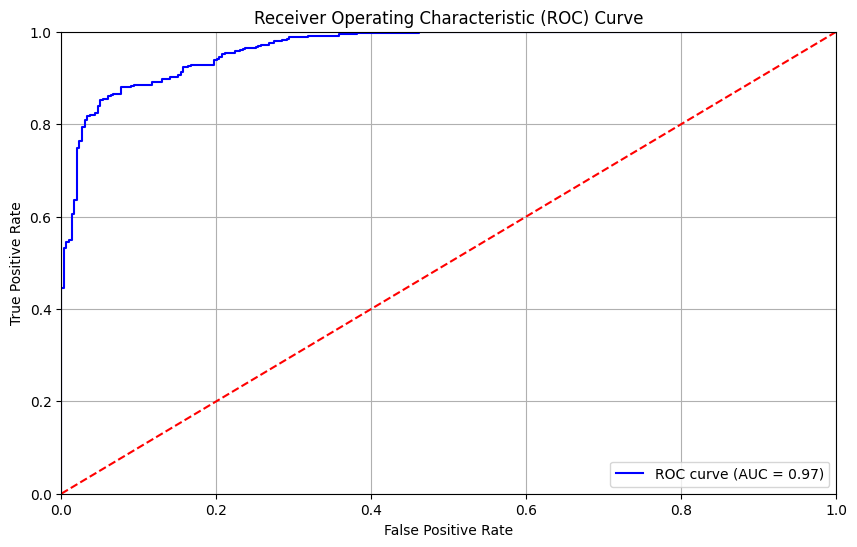

In [36]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Serializing the Models

In [37]:
import joblib

# Saving the model
joblib.dump(rf, r'C:\Users\Blen\OneDrive\Desktop\10Academy\CreditScoreModeling\models\random_forest_model.pkl')


['C:\\Users\\Blen\\OneDrive\\Desktop\\10Academy\\CreditScoreModeling\\models\\random_forest_model.pkl']

In [38]:
joblib.dump(gbm, r'C:\Users\Blen\OneDrive\Desktop\10Academy\CreditScoreModeling\models\gradient_boosting_model.pkl')

['C:\\Users\\Blen\\OneDrive\\Desktop\\10Academy\\CreditScoreModeling\\models\\gradient_boosting_model.pkl']

In [39]:
joblib.dump(logreg, r'C:\Users\Blen\OneDrive\Desktop\10Academy\CreditScoreModeling\models\logistic_regression_model.pkl')

['C:\\Users\\Blen\\OneDrive\\Desktop\\10Academy\\CreditScoreModeling\\models\\logistic_regression_model.pkl']